# Comtypes

Comtypes is a library to interact with software that have registered a COM (component object model) interface. The COM interface is stored centrally in Windows, and can be accessed from any software through a unified API. Many softwares have COM interfaces. Previously, it was also known as ActiveX.

https://pythonhosted.org/comtypes/

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Open `comtypes.xlsx`

In [2]:
from comtypes.client import CreateObject

filename = "comtypes.xlsx"
filepath = (Path(".") / filename).absolute()

app = CreateObject("Excel.Application")
app.Visible = True

wb = app.Workbooks.Open(str(filepath))
worksheet = wb.Sheets[1]

AttributeError: module 'comtypes.gen.Excel' has no attribute '_Application'

Read some data

In [ ]:
i = 1
for row in range(10):
    row += 1
    data = worksheet.Cells[row, i].Value()
    print(data)

Write some data

In [ ]:
i = 1
j = 2
for row in range(10):
    row += 1
    data = worksheet.Cells[row, i].Value()
    worksheet.Cells[row, j] = data**2

Slow version

In [ ]:
worksheet = wb.Sheets[2]
I, J = 56, 600
arr = np.empty((I, J))

for i in range(I):
    print(f"Row {i}", end="\r")
    for j in range(J):
        val = worksheet.Cells[i+1, j+1].Value()
        arr[i, j] = val

plt.imshow(arr);

Faster version

In [ ]:
worksheet = wb.Sheets[2]
I, J = 56, 600
arr = np.empty((I, J))

for i in range(I):
    row = worksheet.Rows[i+1].Value()
    row = [value for value in row[0] if value != None]
    arr[i, :] = np.array(row)

plt.imshow(arr);

# ctypes

`ctypes` is a useful library for interfacing with C-code from Python. The examples here show how we can use `ctypes` to implement functions available from the Windows API, and how we can use it to interface with C functions exposed in a DLL.

https://docs.python.org/3.7/library/ctypes.html  

## Increasing the Windows time resolution

Here we use the Windows multimedia API to increase the Windows time resolution (`C:\Windows\System32\winmm.dll`)

https://docs.microsoft.com/en-us/windows/win32/api/timeapi/index    

First we need to import the DLL with ctypes and then map the functions. This is essentially telling Python how to interact with the C API.

In [3]:
from ctypes import wintypes
import ctypes

winmm = ctypes.WinDLL('winmm')

ENABLED = False

class TIMECAPS(ctypes.Structure):
    _fields_ = (('wPeriodMin', wintypes.UINT),
                ('wPeriodMax', wintypes.UINT))

milliseconds = 1  # 1 ms is the smallest possible time period on Windows

Let's time how long it takes to sleep 1 ms...

In [5]:
%%timeit -n 500 -r 3 import time
time.sleep(0.001)

1.12 ms ± 41.8 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)


Where does this number come from? The Windows scheduler ticks 64 times per second:

In [7]:
print(f"Time period @ 64 ticks/s: {1/64 * 1000} ms")

Time period @ 64 ticks/s: 15.625 ms


So, it takes more than 15 ms for the cpu to sleep just 1 ms...  
However, the Windows multimedia library offers functions to adjust the time period when needed. Let's increase the time resolution to 1 ms!

In [8]:
# setup
caps = TIMECAPS()
winmm.timeGetDevCaps(ctypes.byref(caps), ctypes.sizeof(caps))

# check that it is within allowed values
milliseconds = min(max(milliseconds, caps.wPeriodMin), caps.wPeriodMax)

winmm.timeBeginPeriod(milliseconds)

0

Try again:

In [9]:
%%timeit -n 500 -r 3 import time
time.sleep(0.001)

1.12 ms ± 20.2 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)


Much better! Note that this effect is system wide, but we can reset it easily.

In [10]:
# reset
winmm.timeEndPeriod(milliseconds)

0

And to make sure it worked...

In [11]:
%%timeit -n 500 -r 3 import time
time.sleep(0.001)

1.14 ms ± 35.6 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)


Changing the time period is useful when higher precision is required on the scheduler, for example when millisecond time precision is needed `time.sleep` for time-sensitive programs.

## Interfacing with a DLL

A cmore complex, but real-world example of how to interface a DLL that reads data from a camera mounted under a TEM. Again, we will use `ctypes` for this.

This example is taken from:
https://github.com/stefsmeets/instamatic/blob/master/instamatic/camera/camera_gatan.py

In [12]:
import ctypes
from ctypes import c_int, c_long, c_float, c_double, c_bool, c_wchar_p
from ctypes import POINTER, byref, addressof

The only thing we have is a header file (`CCDCOM.h`) and a dll (`CCDCOM2_x64_simulation.dll`), let's see if we can get some data out of this thing. Note that this DLL simulates the connection, and makes up some data for debugging purposes.

In [14]:
with open("CCDCOM.h", "r") as f:
    for line in f:
        print(line, end="")

int initCCDCOM(int nNumber);
void releaseCCDCOM(void);

//Whether the camera reports its name and sizes
bool isCameraInfoAvailable();

bool cameraName(wchar_t* wcName, 
                int wcNameSize);

bool cameraDimensions(int* pnWidth, 
                      int* pnHeight);

int cameraCount(void);

int execScript(const wchar_t* script);

int acquireImageNewInt(int area_t, 
                       int area_l, 
                       int area_b, 
                       int area_r,
                       int* pdata, 
                       int* pnImgWidth, 
                       int* pnImgHeight, 
                       int nBinning, 
                       double fExposure, 
                       bool bShowInDM);

int acquireImageNewFloat(int area_t, 
                         int area_l, 
                         int area_b, 
                         int area_r, 
                         int nBinning, 
                         double fExposure, 
                         bool bShowInD

So the symbols are defined in the header, but they are a bit mangled, it does not matter, because we can make a mapping.  
You can use #dependency walker to get function names from DLL: http://www.dependencywalker.com/

In [15]:
symbols = {
        'acquireImageNewFloat' : '?acquireImageNewFloat@@YAHHHHHHN_NPEAPEAMPEAH2@Z',
        'acquireImageNewInt' : '?acquireImageNewInt@@YAHHHHHPEAH00HN_N@Z',
        'cameraCount' : '?cameraCount@@YAHXZ',
        'cameraDimensions' : '?cameraDimensions@@YA_NPEAH0@Z',
        'cameraName' : '?cameraName@@YA_NPEA_WH@Z',
        'CCDCOM2_release' : '?CCDCOM2_release@@YAXPEAM@Z',
        'initCCDCOM' : '?initCCDCOM@@YAHH@Z',
        'isCameraInfoAvailable' : '?isCameraInfoAvailable@@YA_NXZ',
        'releaseCCDCOM' : '?releaseCCDCOM@@YAXXZ'
        }

Next, we load the DLL using ctypes

In [16]:
libpath = (Path() / "CCDCOM2_x64_simulation.dll").absolute()

lib = ctypes.cdll.LoadLibrary(str(libpath))

All the functions are defined in the header file, and we get them as attributes from `lib`  
Simple functions are easily interfaced, such as the following, which checks if the camera info is available.  
We define the interface and the return type as a boolean (`c_bool`).

In [17]:
isCameraInfoAvailable = getattr(lib, symbols['isCameraInfoAvailable'])
isCameraInfoAvailable.restype = c_bool

print(f"Camera available: {isCameraInfoAvailable()}")

Camera available: False


Easy enough, what about getting the image dimensions.  
First we define the function `cameraDimensions`. Because we know the arguments are pointers to where the height and width are stored as floats (`c_long`), we must define the arguments as such. This function does not return, so we do not have to specify the return type (`restype`) as above.

In [18]:
cameraDimensions = getattr(lib, symbols['cameraDimensions'])
cameraDimensions.argtypes = [POINTER(c_long), POINTER(c_long)]

Next we can define our own interface, and neatly wrap it in a python interface.  
Initialze the width (`pnWidth`) and height (`pnHeight`) as integers, and pass them by reference (`byref`)

In [20]:
def get_dimensions():
    pnWidth = c_int(0)
    pnHeight = c_int(0)
    cameraDimensions(byref(pnWidth), byref(pnHeight))
    return pnWidth.value, pnHeight.value

print(get_dimensions())

(1024, 1024)


Ok, that worked, what about a more complex function, such as obtaining the image, which is what we are after.  
The trick is the same as above, 1) map the function, 2) specify the arguments (`argtypes`), and 3) specify the return type (`restype`).

In [21]:
acquireImageNewFloat = getattr(lib, symbols['acquireImageNewFloat'])
acquireImageNewFloat.argtypes = [
    ## Input
    c_int,    # int area_t 
    c_int,    # int area_l 
    c_int,    # int area_b
    c_int,    # int area_r
    c_int,    # float nBinning
    c_double, # double fExposure
    c_bool,   # bool bShowInDM
    ## Output
    POINTER(POINTER(c_float)), # float** pdata
    POINTER(c_int),            # int* pnImgWidth
    POINTER(c_int)             # int* pnImgHeight
]

# we must also interface the function to free the memory after the image is retrieved
CCDCOM2release = getattr(lib, symbols['CCDCOM2_release'])
CCDCOM2release.argtypes = [POINTER(c_float)]

Again, we define a function to hide all the messy details to get this to work

In [22]:
def get_image(exposure=0.1):
    xmin, ymin = 0, 0
    xmax, ymax = get_dimensions()
    
    pdata = POINTER(c_float)()
    pnImgWidth = c_int(0)
    pnImgHeight = c_int(0)
    
    acquireImageNewFloat(ymin, xmin, ymax, xmax, 
                         1, 
                         exposure, 
                         False, 
                         byref(pdata), 
                         byref(pnImgWidth), 
                         byref(pnImgHeight)
                         )
    
    # the image dimensions are stored here
    xres = pnImgWidth.value
    yres = pnImgHeight.value
    
    # here we calculate the memory space that is addressed from the address of the
    # `pdata` pointer by multiplying the number of pixels (`xres`*`yres`) by the
    # a floating point in memory ad converting that to a numpy array... oof!
    arr = np.ctypeslib.as_array((c_float * xres * yres).from_address(addressof(pdata.contents)))
    
    arr = arr.copy()
    
    # we must tell the DLL to release the memory
    CCDCOM2release(pdata)
    
    return arr
    

Let's see what we got!

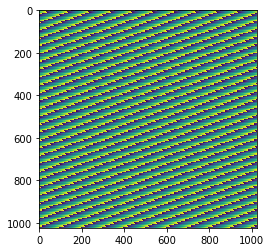

In [23]:
arr = get_image()
plt.imshow(arr);

# Subprocess

https://docs.python.org/3.7/library/subprocess.html

Subprocesses are convenient to call programs from Python. This can be any program that is accessible through the Windows command line.

In [24]:
import subprocess as sp

For example, we can start notepad

In [25]:
p = sp.run("notepad.exe")

But we can also call other programs, like `sginfo`:  
http://cci.lbl.gov/sginfo/

Sginfo is a command line program that gives space group information. We can specify the space group we are interested in, and capture the output.

In [26]:
p = sp.run("sginfo Pnma -allxyz", capture_output=True)
print(p.stdout.decode())

# sginfo Pnma -allxyz

Space Group  62  D2h^16  Pnma  -P 2ac 2n
Point Group  mmm
Laue  Group  mmm
Orthorhombic

Order     8
Order P   8

s.s.Vector  Modulus
  1  0  0   2
  0  1  0   2
  0  0  1   2

# Inversion-Flag = 0
x, y, z
-x+1/2, -y, z+1/2
x+1/2, -y+1/2, -z+1/2
-x, y+1/2, -z
# Inversion-Flag = 1
-x, -y, -z
x+1/2, y, -z+1/2
-x+1/2, y+1/2, z+1/2
x, -y+1/2, z

Grid Special Positions          2  4  2
Grid Symmetry Operations        4  4  4
Grid Screw/Glide Translations   2  2  2




We can then write a little function to wrap some of the information we are interested.  
For example, we want to obtain the Laue group for any space group. We will raise an error if the space group cannot be found.

In [27]:
class SpaceGroupError(NameError):
    pass

def get_laue_group(spgr):
    p = sp.run(f"sginfo {spgr}", capture_output=True)
    stdout = p.stdout.decode()
    stderr = p.stderr.decode()
    
    for line in p.stdout.decode().splitlines():
        if line.startswith("Laue  Group"):
            ret = line.split()[2]
            return ret

    raise SpaceGroupError(stderr)

spgr = "Pnma"
lauegr = get_laue_group(spgr)
print(f"The Laue group for `{spgr}` is `{lauegr}`")

The Laue group for `Pnma` is `mmm`


# WSL

Windows Subsystem for Linux (WSL) is a feature in Windows 10 that allows you to run native Linux executables directly on Windows.

In [28]:
import subprocess as sp

p = sp.run("bash -ic xds", capture_output=True)
print(p.stdout.decode())
print(p.stderr.decode())


 ***** XDS ***** (VERSION Mar 15, 2019  BUILT=20190806)  17-Aug-2019
 Author: Wolfgang Kabsch
 Copy licensed until 31-Mar-2020 to
  academic users for non-commercial applications   
 No redistribution.

  !!! ERROR !!! CANNOT OPEN OR READ XDS.INP




Can we run Linux GUI programs from Python through WSL?

For this to work Xming X server for Windows should be installed:  
https://sourceforge.net/projects/xming/

This makes sure that Windows knows how to render the GUI programs invoked from bash.

Also, set the `DISPLAY` environment variable (or add it to `~/.bashrc`):  
`export DISPLAY=:0`

In [29]:
import subprocess as sp

p = sp.run("bash -ic xdsgui", capture_output=True)
print(p.stdout.decode())
print(p.stderr.decode())

/usr/local/bin/xds_par
/usr/local/bin/xds-viewer
/usr/local/bin/xdsconv
/usr/local/bin/xscale_par

Object::connect: No such signal XdsconvTab::signalSetTabEnabled(QWidget*,bool)
Object::connect:  (sender name:   'xdsconv')
Object::connect:  (receiver name: 'tabWidget')



# Sockets

Sockets are used for communicating between different programs, locally or over the network. In fact, the python multiprocessing library makes heavy use of sockets for interprocess communcation to achieve parallel processing. Here we will use it to transmit message between a server and a client program.

https://docs.python.org/3/library/socket.html

First, set some ports. Localhost refers to the local computer, but you can put an ip address here to establish a connection over the network. The port indicates the port over which communcation takes place, and `BUFF` refers to the maximum message length.

In [30]:
from socket import *

HOST = 'localhost'
PORT = 8009
BUFF = 1024

The first example uses Python sockets to establish the connection with the server. First run the `glue echo server.ipynb` notebook.

In [31]:
payload = "Hello world!"

with socket(AF_INET, SOCK_STREAM) as s:
    print("Sending message to server...")
    
    s.connect((HOST, PORT))
    s.send(payload.encode())

    msg = s.recv(BUFF).decode()
    print("Answer ->", msg)

Sending message to server...
Answer -> You sent: 'Hello world!'


The cool thing is, we can actually do the same thing through Python by calling netcat directly using subprocesses

In [ ]:
import subprocess as sp

In [ ]:
msg = "Hello through netcat!".encode()

p = sp.run(f"./nc {HOST} {PORT}", input=msg, capture_output=True)
msg = p.stdout.decode()

print(msg)

The way this works is through pipes. Much like in the command line, software pipes can be specified in Python's subprocess using the following syntax. `sp.run` is nothing more than a wrapper around `sp.Popen` that simplifies this interface.

In [ ]:
p1 = sp.Popen(f"./nc {HOST} {PORT}", stdout=sp.PIPE, stdin=sp.PIPE)

data = "Hello through netcat (using sp.Popen)!".encode()

msg = p1.communicate(data)[0].decode()
print(msg)

You can send any data over the network, but you have to make a bytes representation first. `pickle` is a good way to serialize python data.

In [ ]:
import pickle

arr = [1, 2, 3, 4, 5, 6, 7, 8, 9]

payload = pickle.dumps(arr)

payload

If you now run the second server in the notebook, we can make it calculate the sum of the list above.

In [ ]:
with socket(AF_INET, SOCK_STREAM) as s:
    print("Sending message to server...")
    
    s.connect((HOST, PORT))
    s.send(payload)

    msg = pickle.loads(s.recv(BUFF))
    print("Answer ->", msg)

This is extremely powerful and quite easy to set up!

# PyAutoGui

If all other options fail, `pyautogui` is a last resort option. It can find UI elements on the screen, and automate interactions, such as clicking on buttons.

https://pypi.org/project/PyAutoGUI/#files

In [32]:
import pyautogui as pg

import imageio
import matplotlib.pyplot as plt

First, we define an image to click on.

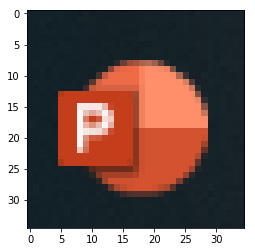

In [33]:
click_target = "pp.png"

data = imageio.imread(click_target)

plt.imshow(data)

Then, `pyautogui` can find the button on the screen and click on it :-)

In [34]:
pos = pg.locateCenterOnScreen(click_target)
pg.moveTo(pos, duration=2.0, pause=1.0, tween=pg.easeOutQuad)  # add delay for dramatic effect
pg.click()
pg.hotkey("shift", "f5")